<a href="https://colab.research.google.com/github/AlicjaTomaszewska/Neutral_Network_Stock/blob/main/Kopia_notatnika_Projekt_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Apr 10 10:17:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!gdown 1M_YjQxTNTYPgJa4ABjTHiYa7fOd2wVL3

Downloading...
From: https://drive.google.com/uc?id=1M_YjQxTNTYPgJa4ABjTHiYa7fOd2wVL3
To: /content/Alice_AI.zip
100% 55.0k/55.0k [00:00<00:00, 53.7MB/s]


In [3]:
!unzip Alice_AI.zip

Archive:  Alice_AI.zip
  inflating: Alice_AI/123.ipynb      
  inflating: Alice_AI/mwig40.csv     
  inflating: Alice_AI/wig20.csv      


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import pandas as pd
import tensorflow.compat.v2 as tf
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [27]:
df_WIG20 = pd.read_csv('/content/Alice_AI/wig20.csv', header=0) #loading data
df_mWIG40 = pd.read_csv('/content/Alice_AI/mwig40.csv', header=0)

In [28]:
df_WIG20['Data'] = pd.to_datetime(df_WIG20['Data'], format='%Y-%m-%d') #changing to data format
df_mWIG40['Data'] = pd.to_datetime(df_mWIG40['Data'], format='%Y-%m-%d')

In [29]:
df = pd.merge(left=df_WIG20, right=df_mWIG40, how='left', left_on='Data', right_on='Data') #merging two tables

In [30]:
df['Rok'] = df['Data'].dt.year  #Creating 3 new columns: Year, Month and Day and dropping Date column
df['Miesiąc'] = df['Data'].dt.month
df['Dzień'] = df['Data'].dt.day
df.drop(['Data'], axis=1, inplace=True)
df.drop(['Najwyzszy_x', 'Najwyzszy_y', 'Najnizszy_x', 'Najnizszy_y', 'Wolumen_x', 'Wolumen_y'], axis=1, inplace=True) #dropping unnecessary columns

In [31]:
df['Otwarcie_x'] = pd.to_numeric(df['Otwarcie_x'], errors='coerce') #changing format to numeric
df['Otwarcie_y'] = pd.to_numeric(df['Otwarcie_y'], errors='coerce')
df['Zamkniecie_x'] = pd.to_numeric(df['Zamkniecie_x'], errors='coerce')
df['Zamkniecie_y'] = pd.to_numeric(df['Zamkniecie_y'], errors='coerce')


In [32]:
df.dropna(axis=0, inplace=True)

In [33]:
df_t_minus_5 = df.iloc[0:-5, :].reset_index(drop=True)
df_t_minus_4 = df.iloc[1:-4, :-3].reset_index(drop=True)
df_t_minus_3 = df.iloc[2:-3, :-3].reset_index(drop=True)
df_t_minus_2 = df.iloc[3:-2, :-3].reset_index(drop=True)
df_t_minus_1 = df.iloc[4:-1, :-3].reset_index(drop=True)

In [34]:
df_features = pd.concat([df_t_minus_5, df_t_minus_4, df_t_minus_3, df_t_minus_2, df_t_minus_1], axis=1) #creating features table

df_target = df.iloc[5:, 0].reset_index(drop=True)

X = df_features.values
Y = df_target.values

In [35]:
print(df.head(10))
print(df_target.head(10))
print(df_features.head(10))

   Otwarcie_x  Zamkniecie_x  Otwarcie_y  Zamkniecie_y   Rok  Miesiąc  Dzień
0     2250.26       2272.09     4706.96       4698.32  2018        3     20
1     2268.87       2320.77     4706.00       4735.44  2018        3     21
2     2313.07       2274.10     4728.41       4652.00  2018        3     22
3     2254.88       2257.22     4626.77       4611.80  2018        3     23
4     2260.83       2240.65     4604.79       4557.61  2018        3     26
5     2258.98       2246.32     4594.24       4566.10  2018        3     27
6     2238.85       2203.70     4557.36       4531.28  2018        3     28
7     2215.94       2210.38     4539.87       4554.89  2018        3     29
8     2211.17       2239.15     4546.27       4559.40  2018        4      3
9     2238.25       2200.99     4574.04       4599.98  2018        4      4
0    2258.98
1    2238.85
2    2215.94
3    2211.17
4    2238.25
5    2222.86
6    2244.33
7    2261.72
8    2280.21
9    2274.22
Name: Otwarcie_x, dtype: float64
 

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=123) #we take 20% of data to test


In [37]:
#Normalization
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean)/ std
X_test = (X_test - mean)/ std

In [100]:
#Network architecture
n_features = X_train.shape[1]
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(n_features,))) #layer with 64 neurons
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  #output layer with one neuron
optimizers.RMSprop(learning_rate = 0.005) #learning algorithm, learning rate=0.001


In [101]:
#Network training
model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
filepath = 'models/{epoch:02d}-{loss:.0f}-{val_loss:.0f}-{mae:.0f}-{val_mae:.0f}.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience=50), #helps to avoid overfitting or overtraining
            ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]
history = model.fit(X_train, Y_train, validation_split=0.15, epochs=75, callbacks=callbacks, batch_size=32)


Epoch 1/75
27/27 [==============================] - 1s 9ms/step - loss: 4203905.0000 - mae: 2032.2772 - val_loss: 4141097.7500 - val_mae: 2017.0396
Epoch 2/75
27/27 [==============================] - 0s 5ms/step - loss: 4151167.0000 - mae: 2019.0026 - val_loss: 4069322.2500 - val_mae: 1998.5858
Epoch 3/75
27/27 [==============================] - 0s 5ms/step - loss: 4057814.0000 - mae: 1994.9541 - val_loss: 3954412.7500 - val_mae: 1968.4800
Epoch 4/75
27/27 [==============================] - 0s 5ms/step - loss: 3914002.5000 - mae: 1957.1211 - val_loss: 3786327.5000 - val_mae: 1923.2574
Epoch 5/75
27/27 [==============================] - 0s 5ms/step - loss: 3721237.5000 - mae: 1904.8026 - val_loss: 3570155.7500 - val_mae: 1862.4734
Epoch 6/75
27/27 [==============================] - 0s 4ms/step - loss: 3474795.0000 - mae: 1834.8517 - val_loss: 3302674.7500 - val_mae: 1783.3579
Epoch 7/75
27/27 [==============================] - 0s 5ms/step - loss: 3183136.0000 - mae: 1746.3915 - val_loss

In [102]:
#Testing set evaluation
MSE, MAE = model.evaluate(X_test, Y_test)
print(MSE, MAE)


8/8 [==============================] - 0s 3ms/step - loss: 7345.4248 - mae: 68.3454
7345.4248046875 68.34540557861328


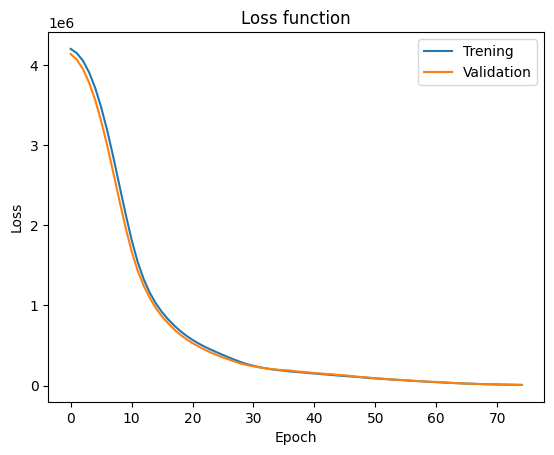

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Trening', 'Validation'], loc='upper right')
plt.show()



In [ ]:
# save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# load model
import os
import pickle

# Change the current working directory to 'Alice_AI'
os.chdir('/content/Alice_AI')

# Open the 'model.pkl' file and load the model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
!zip models


zip error: Nothing to do! (models.zip)


In [ ]:
pwd

'/content/Alice_AI'

In [ ]:
!zip -r /content/Alice_AI.zip /content/Alice_AI



  adding: content/Alice_AI/ (stored 0%)
  adding: content/Alice_AI/mwig40.csv (deflated 60%)
  adding: content/Alice_AI/.ipynb_checkpoints/ (stored 0%)
  adding: content/Alice_AI/wig20.csv (deflated 62%)
  adding: content/Alice_AI/models/ (stored 0%)
  adding: content/Alice_AI/models/03-303246-188998-435-362.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/18-640-760-19-24.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/16-839-936-22-25.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/10-14119-10027-93-79.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/52-433-464-15-16.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/01-2374375-624754-1398-647.hdf5 (deflated 35%)
  adding: content/Alice_AI/models/12-4297-3556-51-47.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/13-2588-1345-39-28.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/05-143166-115308-305-261.hdf5 (deflated 40%)
  adding: content/Alice_AI/models/83-415-96-15-8.hdf5 (deflated 40%)
  addin

In [ ]:
from google.colab import files
files.download('/content/Alice_AI.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [104]:
# Create a Linear Regression object
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

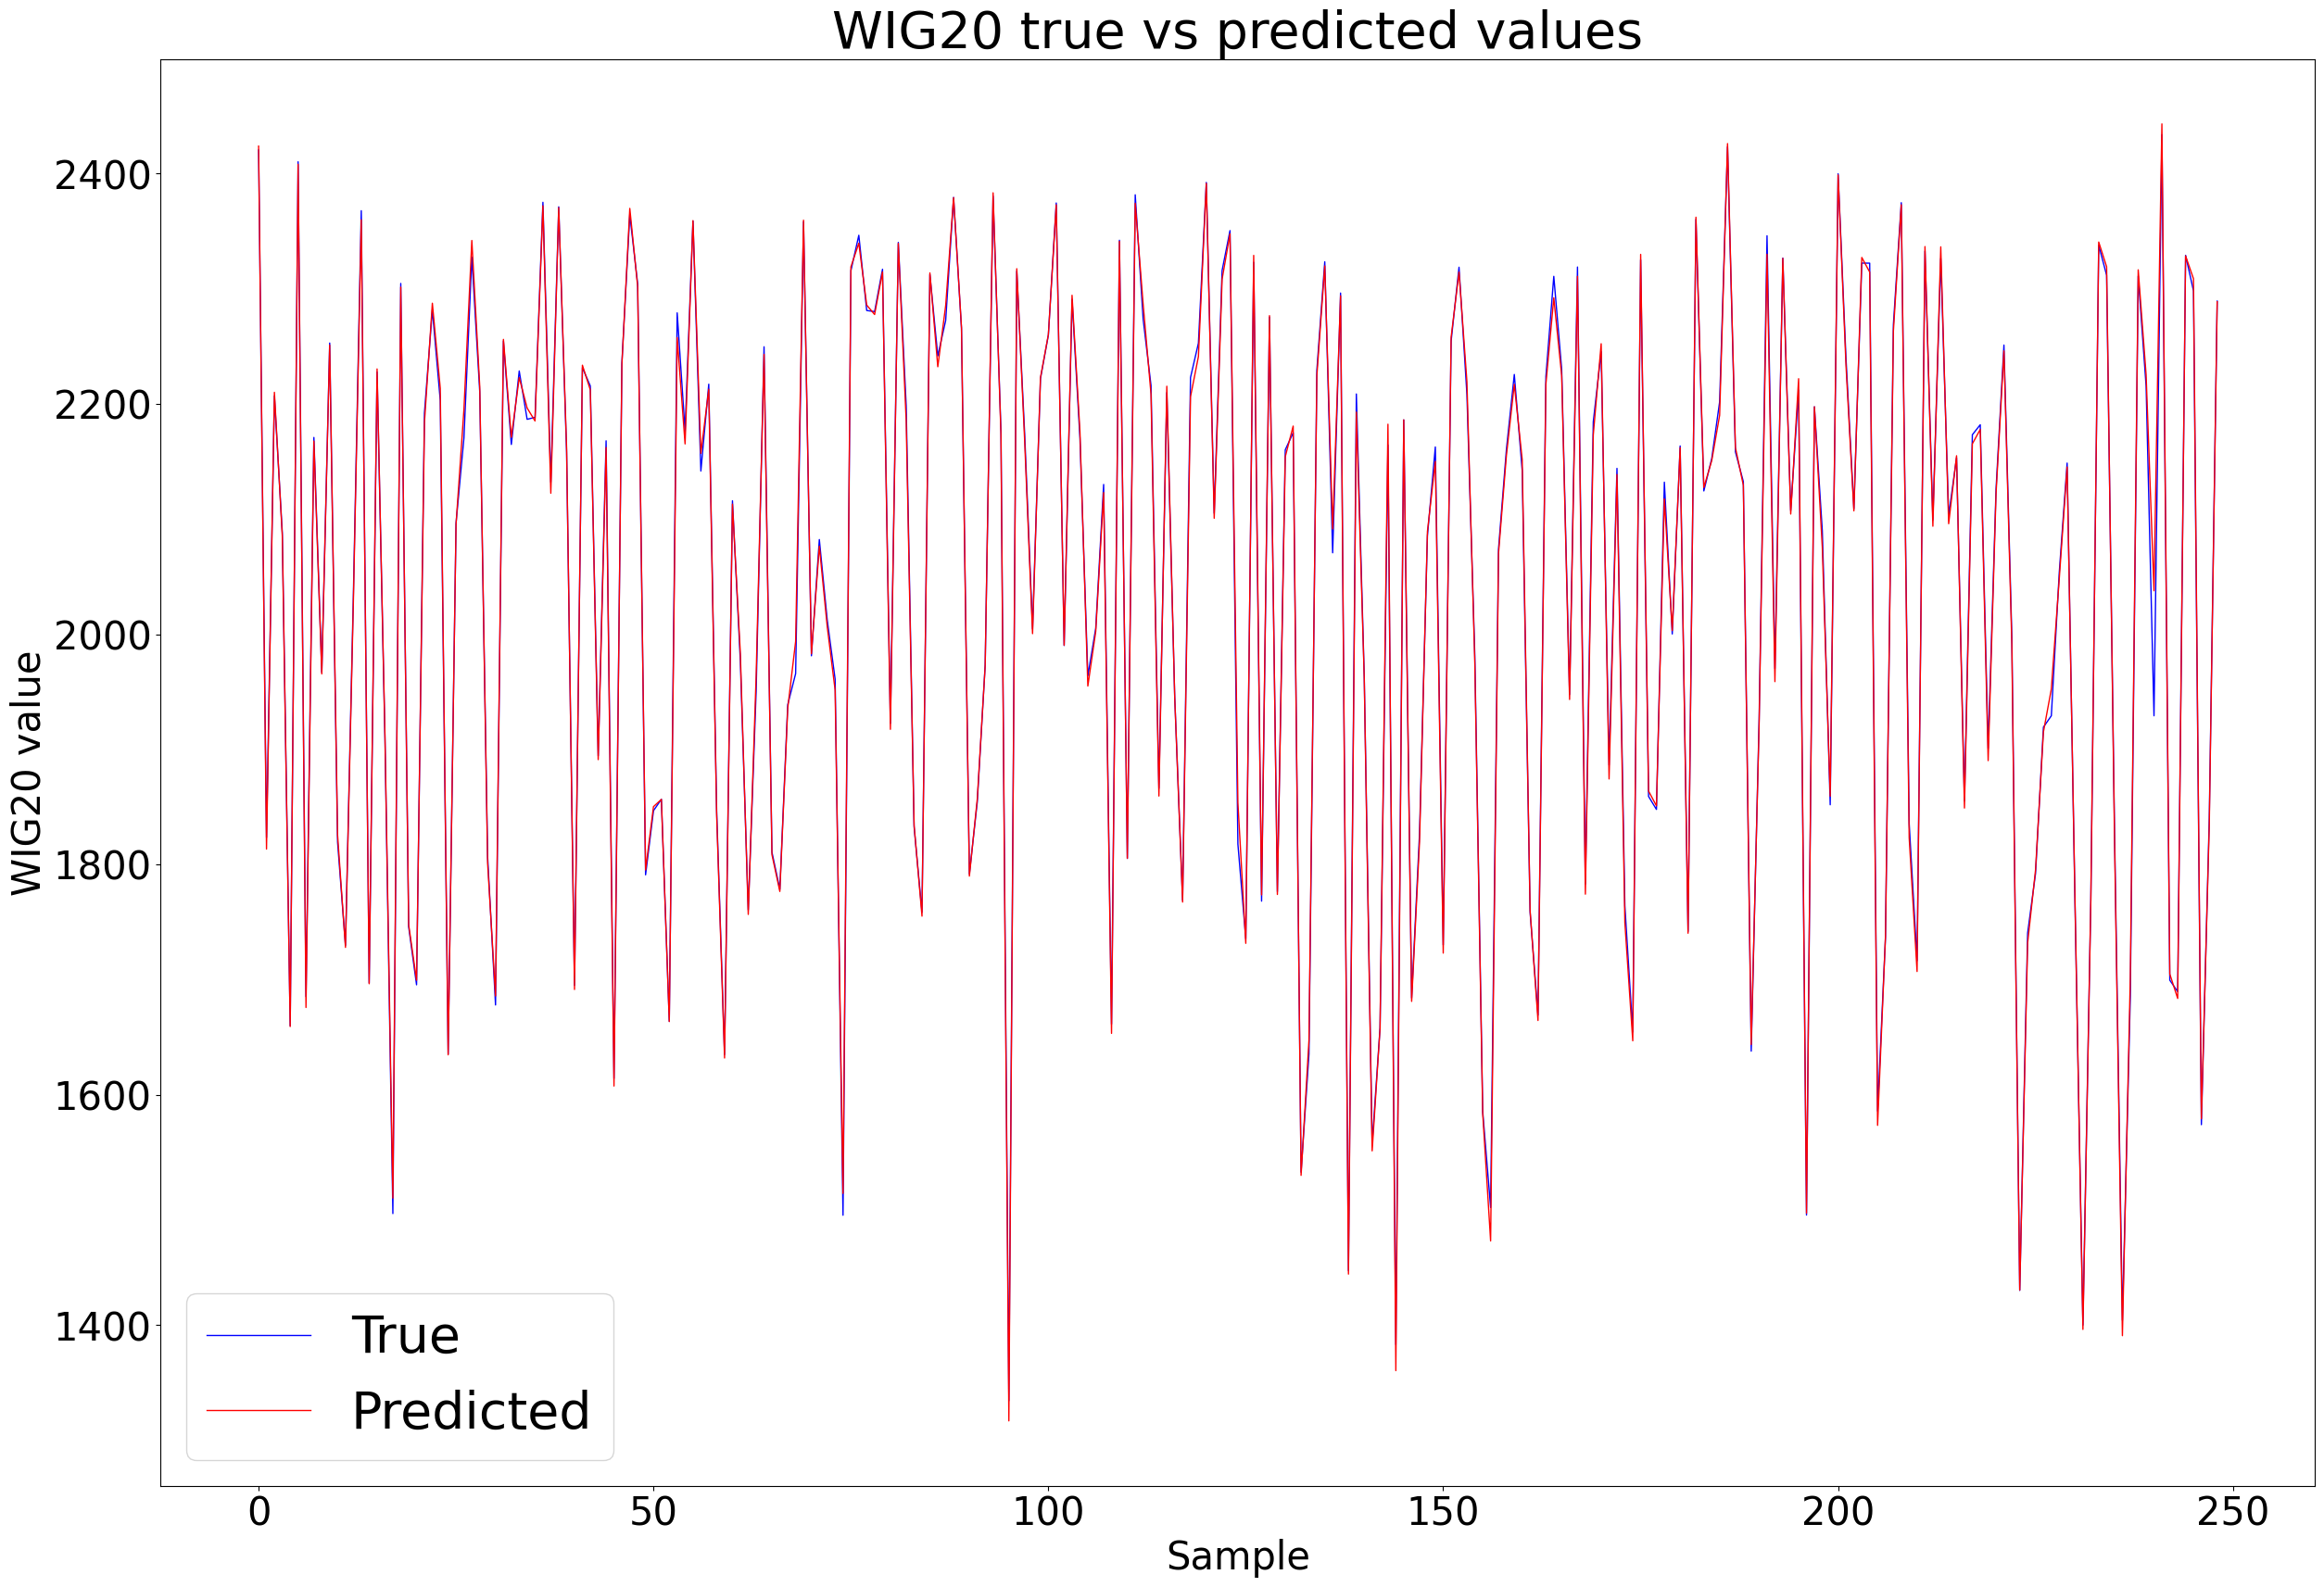

In [106]:
# Predictions on test set
y_pred = model.predict(X_test)

# Plotting predicted and true values
fig = plt.figure(figsize=(30, 20), dpi=100) # Set figure size and dpi
plt.plot(Y_test, color='blue', label='True', linewidth=1)
plt.plot(y_pred, color='red', label='Predicted', linewidth=1)
plt.xlabel('Sample', fontsize = 30)
plt.ylabel('WIG20 value', fontsize = 30)
plt.title('WIG20 true vs predicted values', fontsize = 40)
plt.legend(prop={"size":40})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()


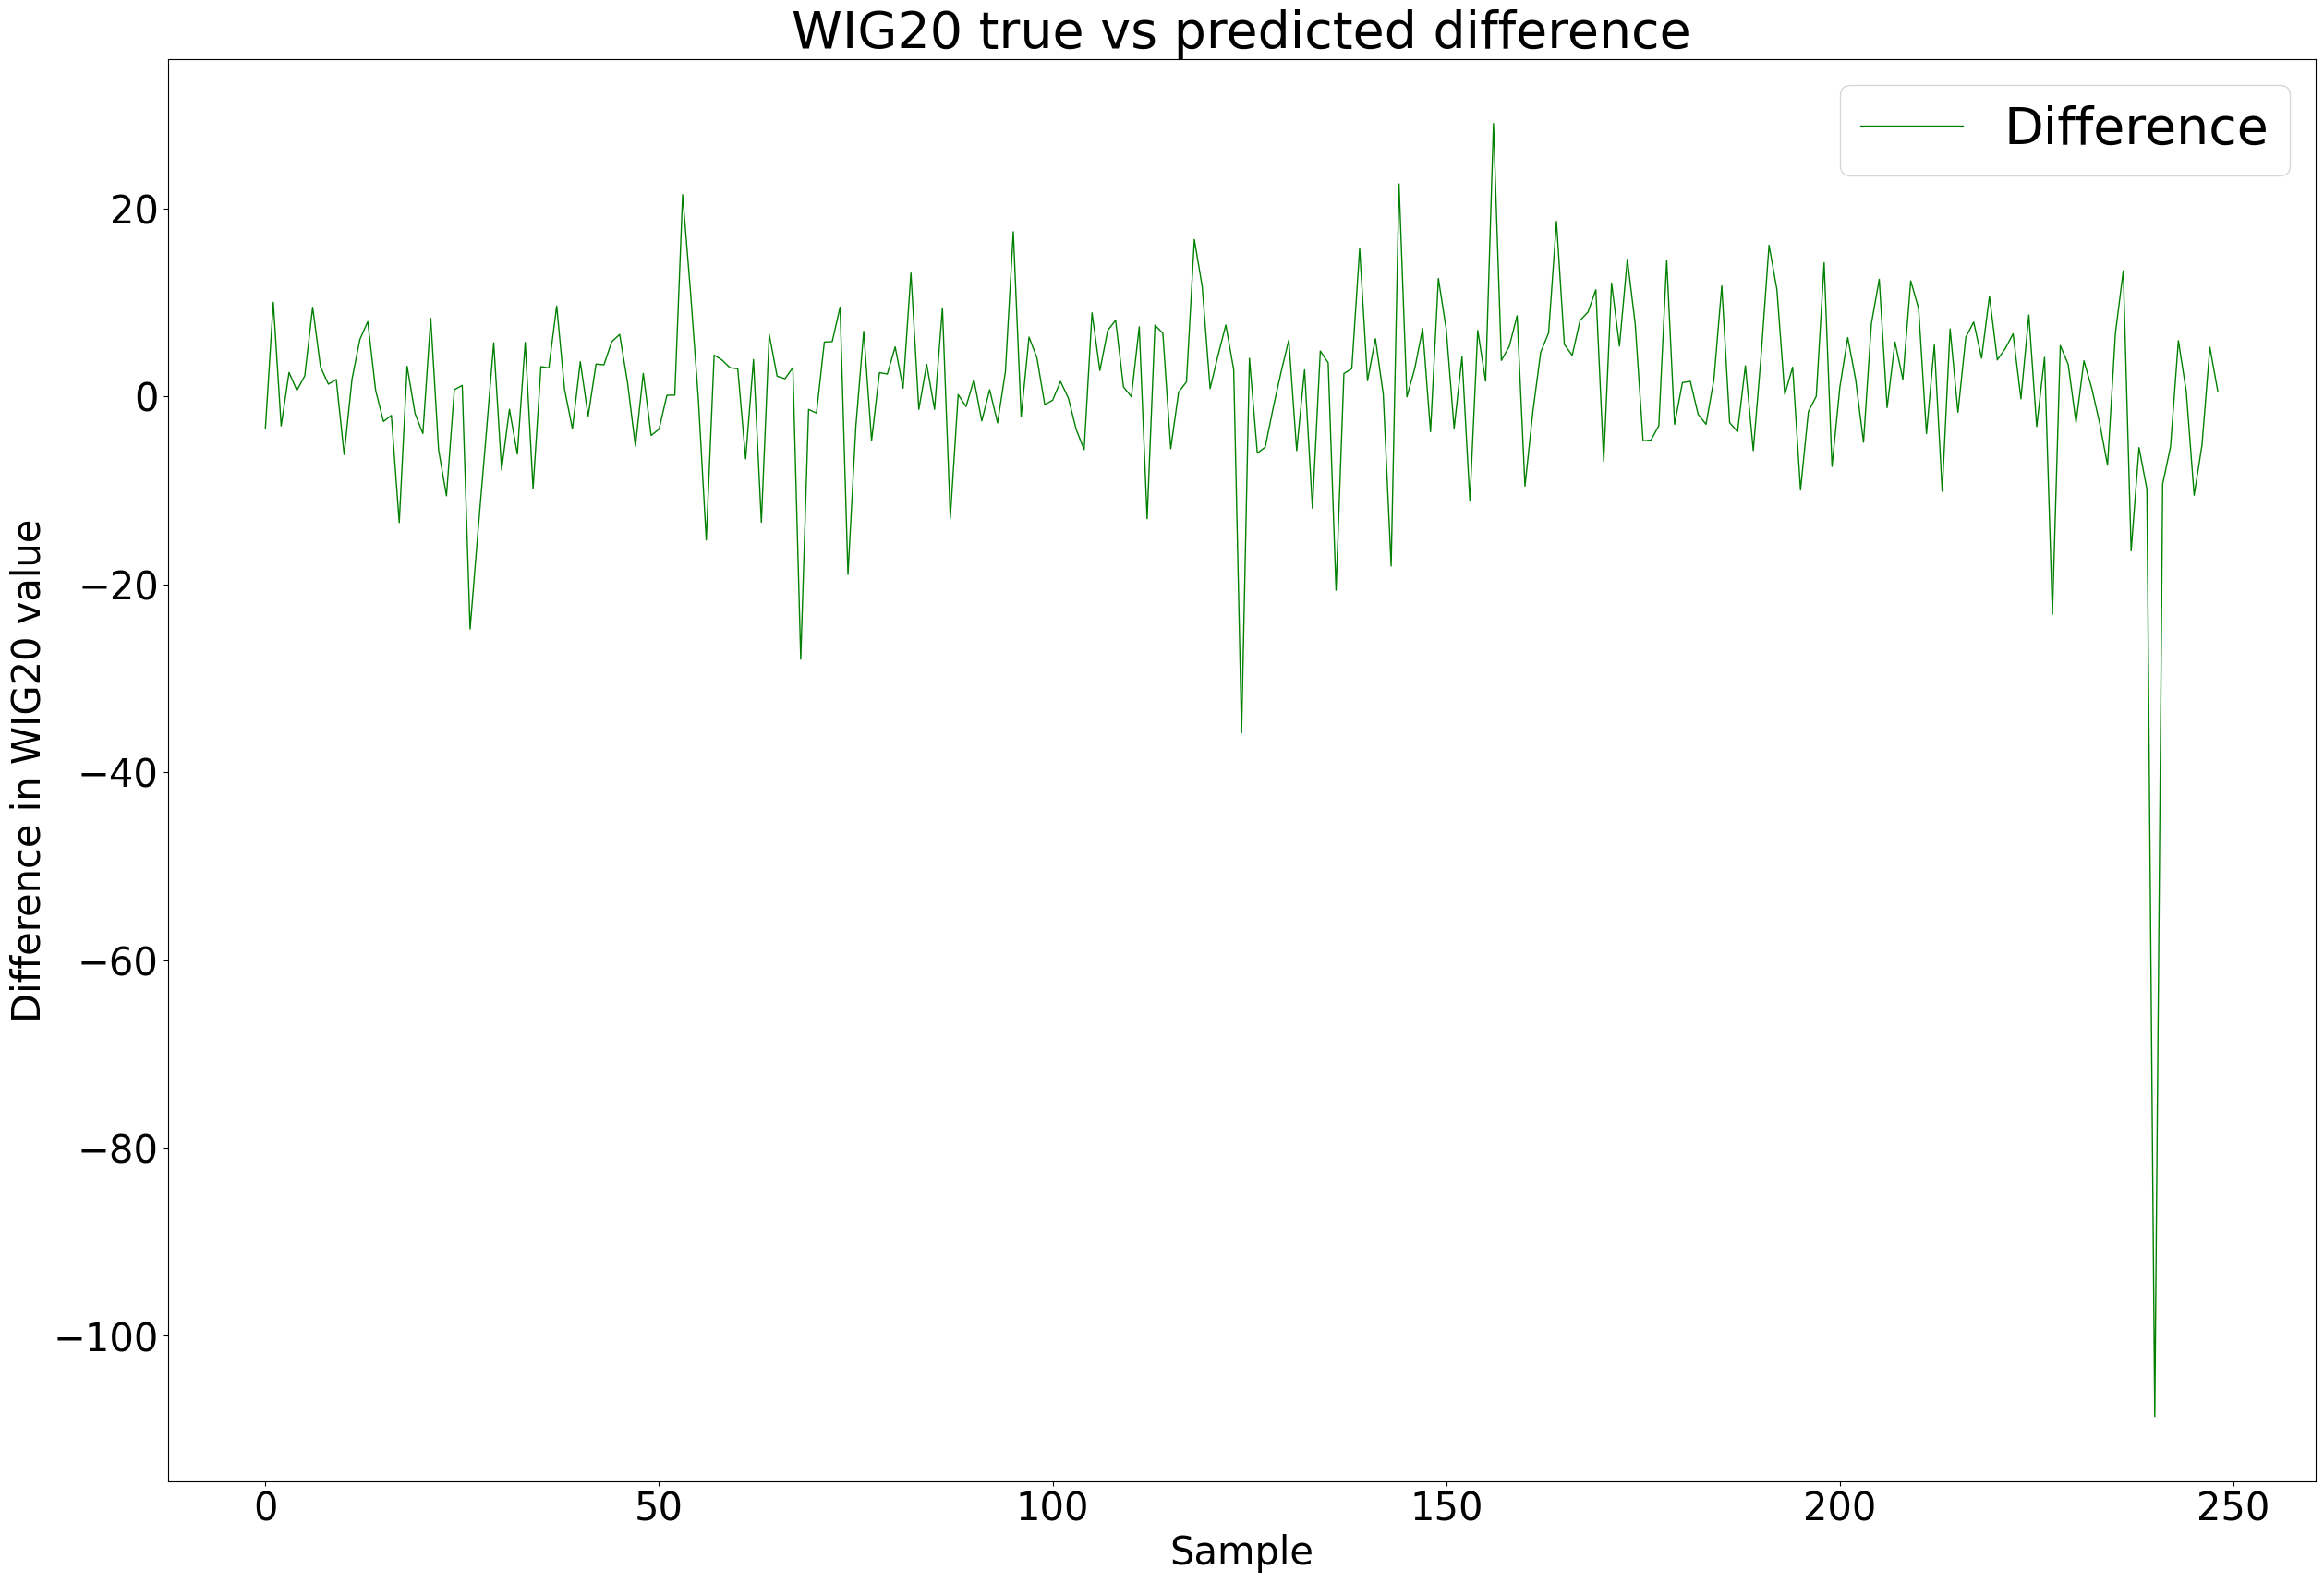

In [108]:
# Predictions on test set
y_pred = model.predict(X_test)

# Calculating the difference between predicted and true values
diff = Y_test - y_pred

# Plotting the difference
fig = plt.figure(figsize=(30, 20), dpi=100) # Set figure size and dpi
plt.plot(diff, color='green', label='Difference', linewidth=1)
plt.xlabel('Sample', fontsize = 30)
plt.ylabel('Difference in WIG20 value', fontsize = 30)
plt.title('WIG20 true vs predicted difference', fontsize = 40)
plt.legend(prop={"size":40})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()


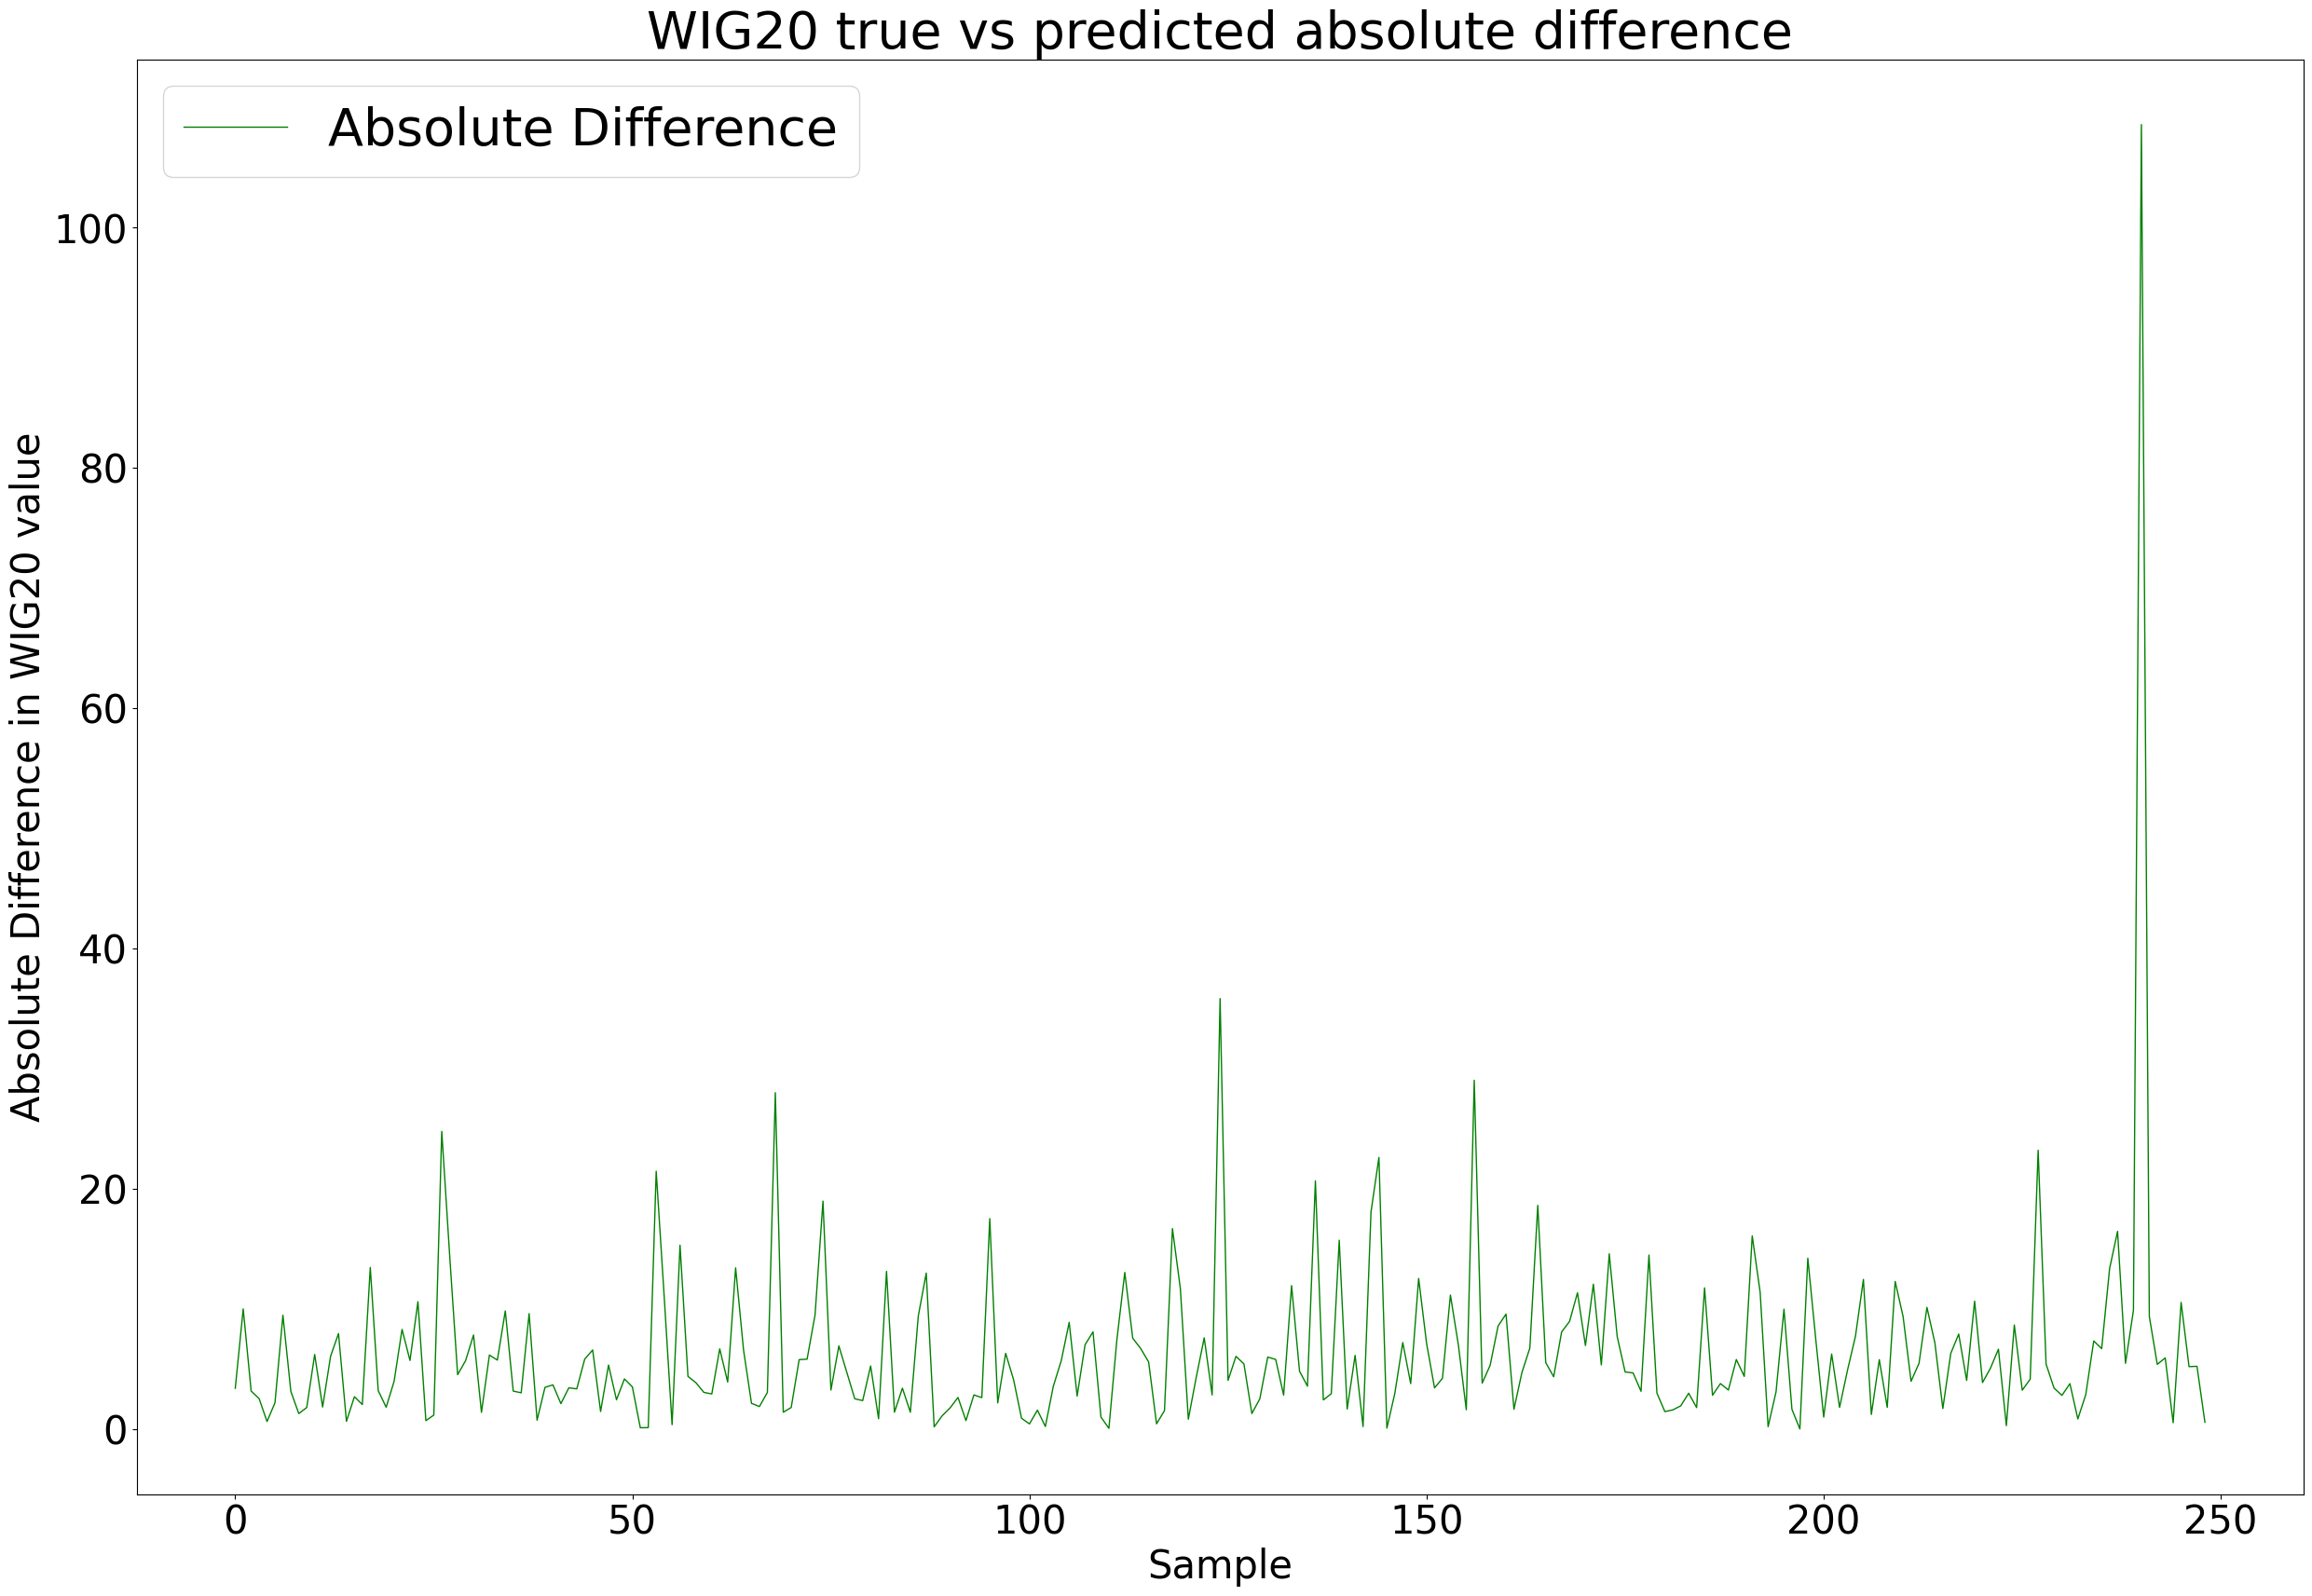

In [109]:
# Predictions on test set
y_pred = model.predict(X_test)

# Calculating the difference between predicted and true values
diff = np.abs(Y_test - y_pred)

# Plotting the difference
fig = plt.figure(figsize=(30, 20), dpi=100) # Set figure size and dpi
plt.plot(diff, color='green', label='Absolute Difference', linewidth=1)
plt.xlabel('Sample', fontsize = 30)
plt.ylabel('Absolute Difference in WIG20 value', fontsize = 30)
plt.title('WIG20 true vs predicted absolute difference', fontsize = 40)
plt.legend(prop={"size":40})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

